In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import tensorflow as tf

In [2]:
np.random.seed(101)
tf.set_random_seed(101)

## Helper function

In [3]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        """Create a sin(x) dataset"""
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points

        # Dataset
        self.t = np.linspace(xmin, xmax, num_points)
        self.y = np.sin(self.t)


    def ret_true(self, x_series):
        return np.sin(x_series)


    def next_batch(self, batch_size, steps, return_batch_ts=False):
        """Randomly Grab a batch on the sine dataset"""
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size, 1) 

        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )

        # Create batch Time Series on t axis
        t = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y = np.sin(t)

        # Format for RNN
        if return_batch_ts:
            return y[:, :-1].reshape(-1, steps, 1), \
                y[:, 1:].reshape(-1, steps, 1), \
                t
        else:
            return y[:, :-1].reshape(-1, steps, 1), \
                y[:, 1:].reshape(-1, steps, 1)

## Dataset
- Predict a time series shifted 1 unit into future

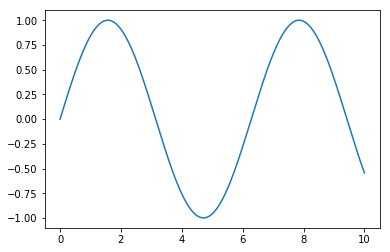

In [4]:
data = TimeSeriesData(
    num_points=250,
    xmin=0,
    xmax=10)

plt.plot(
    data.t,
    data.y)

#### A trainning batch Example

In [5]:
X_batch, y_batch, t = data.next_batch(
    batch_size=1,
    steps=30,
    return_batch_ts=True)

display(X_batch.shape) # X_batch = sin(t0)
display(y_batch.shape) # y_batch = sin(t1)

(1, 30, 1)

(1, 30, 1)

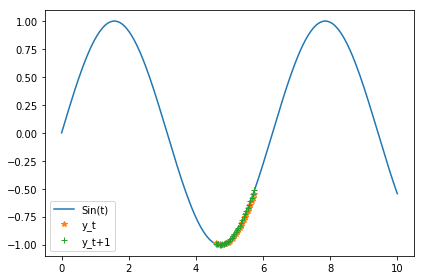

In [6]:
plt.plot(
    data.t,
    data.y,
    label='Sin(t)')

# Input
plt.plot(
    t.flatten()[1:],
    X_batch.flatten(),
    '*',label='y_t')

# Predict
plt.plot(
    t.flatten()[1:],
    y_batch.flatten(),
    '+',label='y_t+1')

plt.legend()
plt.tight_layout()

## Model

#### RNN cells

In [7]:
# Neuron per layer
num_neurons = 100

# Number of layers
n_layers = 3

In [8]:
# Basic RNN cell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(
        num_units=num_neurons,
        activation=tf.nn.relu),
    output_size=1)

In [9]:
# Basic LSTM cell

# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(
#         num_units=num_neurons,
#         activation=tf.nn.relu),
#     output_size=1)

In [10]:
# Deep RNN

# cell = tf.contrib.rnn.MultiRNNCell(
#     [tf.contrib.rnn.BasicRNNCell(num_units=num_neurons) for layer in range(n_layers)])

In [11]:
# cell = tf.contrib.rnn.BasicLSTMCell(
#     num_units=num_neurons,
#     activation=tf.nn.relu)

In [12]:
# Deep LSTM

# cell = tf.contrib.rnn.MultiRNNCell(
#     [tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons) for layer in range(n_layers)])

#### Constants

In [13]:
# Placeholders
X_ph = tf.placeholder(tf.float32, [None, 30, 1])
y_ph = tf.placeholder(tf.float32, [None, 30, 1])

# Graph = RNN cell
y_pred, a_pred = tf.nn.dynamic_rnn(
    cell,
    X_ph,
    dtype=tf.float32)

# loss function: MSE
loss = tf.reduce_mean(tf.square(y_pred - y_ph))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

# Trainning function
train = optimizer.minimize(loss)

In [14]:
# init global var
init = tf.global_variables_initializer()

# saver
saver = tf.train.Saver()

# GPU option
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

# Epochs
epochs = 2001

# MSEs
losses = []

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    # init global var
    sess.run(init)
    
    # Run epochs
    for i in range(epochs):
        # Select a random batch
        X_batch, y_batch = data.next_batch(
            batch_size=1, steps=30)
        
        # train
        sess.run(
            train,
            feed_dict={
                X_ph: X_batch,
                y_ph: y_batch})
        
        if i % 100 == 0:
            # Train mse
            mse = loss.eval(
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch})
            losses.append(mse)

            # PRINT OUT A MESSAGE EVERY 500 STEPS
            if i%500 == 0: 
                print('Epoch: {} - MSE loss = {}'.format(i, mse))
    
    # Save Model for Later
    saver.save(sess, "./model/rnn_time_series_model")

Epoch: 0 - MSE loss = 0.35770273208618164
Epoch: 500 - MSE loss = 0.0006310957833193243
Epoch: 1000 - MSE loss = 0.013372599147260189
Epoch: 1500 - MSE loss = 0.0068531278520822525
Epoch: 2000 - MSE loss = 0.0033351348247379065


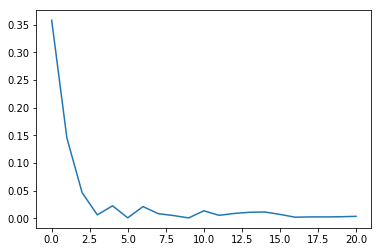

In [15]:
plt.plot(losses)

## Predict timeseries t1

In [16]:
X_predict = np.linspace(5, 5 + data.resolution * (30 + 1), 30+1)
X_predict_sin = np.sin(np.array(X_predict[:-1].reshape(-1, 30, 1)))
y_predict_true = np.sin(X_predict[1:])

display(X_predict_sin.shape)
display(y_predict_true.shape)

(1, 30, 1)

(30,)

In [17]:
with tf.Session() as sess:
    # Load Model
    saver.restore(sess, "./model/rnn_time_series_model")   

    # Predict
    y_predict = sess.run(
        y_pred, 
        feed_dict={
            X_ph: X_predict_sin})
    
y_predict.shape

INFO:tensorflow:Restoring parameters from ./model/rnn_time_series_model


(1, 30, 1)

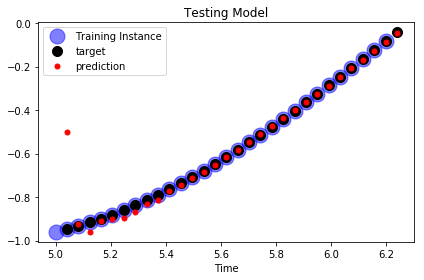

In [18]:
plt.title("Testing Model")

# Plot sine
plt.plot(
    X_predict[:-1],
    np.sin(X_predict[:-1]),
    "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(
    X_predict[1:],
    y_predict_true,
    "ko", markersize=10, label="target")

# Models Prediction
plt.plot(
    X_predict[1:],
    y_predict[0,:,0], 
    "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

## Generating new sequence

#### Train with zeros

In [19]:
with tf.Session() as sess:
    saver.restore(sess, "./model/rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(30)]

    for iteration in range(len(data.t) - 30):
        X_predict = np.array(zero_seq_seed[-30:]).reshape(1, 30, 1)
        y_predict = sess.run(
            y_pred, 
            feed_dict={
                X_ph: X_predict})
        
        zero_seq_seed.append(y_predict[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./model/rnn_time_series_model


Text(0,0.5,'Value')

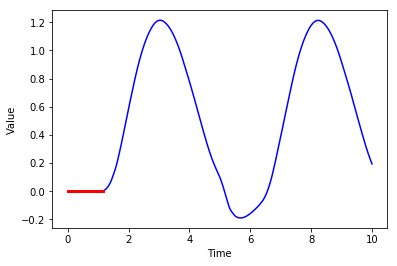

In [20]:
plt.plot(
    data.t,
    zero_seq_seed, "b-")

plt.plot(
    data.t[:30],
    zero_seq_seed[:30],
    "r", linewidth=3)

plt.xlabel("Time")
plt.ylabel("Value")

#### Train with a part of data

In [21]:
with tf.Session() as sess:
    saver.restore(sess, "./model/rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(data.y[:30])

    for iteration in range(len(training_instance) - 30):
        X_predict = np.array(training_instance[-30:]).reshape(1, 30, 1)
        y_predict = sess.run(
            y_pred,
            feed_dict={
                X_ph: X_predict})

        training_instance.append(y_predict[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./model/rnn_time_series_model


Text(0.5,0,'Time')

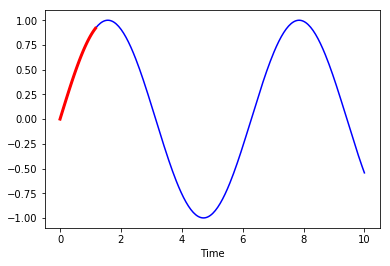

In [22]:
plt.plot(
    data.t,
    data.y,
    "b-")

plt.plot(
    data.t[:30],
    training_instance[:30], 
    "r-", linewidth=3)

plt.xlabel("Time")